# The imports

In [8]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib.pyplot as plt

import mapclassify as mc

# Loading the data

In [9]:
# Load Nepal district geometry data
map_data = gpd.read_file('../data/nepal_map_data/nepal-districts.geojson')

# Lakes data, we only need the 2nd and 3rd columns
lakes_data = gpd.read_file('../data/OpenDataNepal/NepalCBS/number-of-lakes-in-districts-by-altitude-in-nepal.csv').iloc[:, 1:3]

# Preprocess lakes data

In [10]:
# uppercase the district names, cast the count to int
lakes_data['District'] = lakes_data['District'].str.upper()
lakes_data['Total Lake'] = lakes_data['Total Lake'].astype(int)

# join lakes data and geodata on District
final_lakes_data = map_data.merge(lakes_data, how='inner', left_on=["DISTRICT"], right_on=["District"]).iloc[:,1:]

# Plot the number of lakes data as a choropleth

Text(0.5, 1.0, 'Lakes in Nepal (Source: Environment Statistics of Nepal 2019, CBS)')

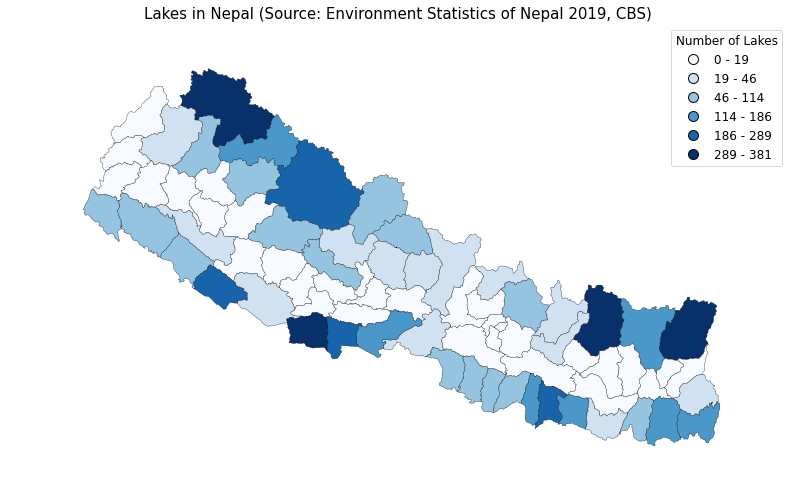

In [11]:
scheme = mc.FisherJenks(final_lakes_data['Total Lake'], k=6)

gplt.choropleth(
    final_lakes_data, figsize=(14,9),
    hue='Total Lake', projection=gcrs.AlbersEqualArea(),
    cmap='Blues', linewidth=0.3, edgecolor='black',
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Number of Lakes",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

plt.title("Lakes in Nepal (Source: Environment Statistics of Nepal 2019, CBS)", fontdict={"fontsize": 15}, pad=5)

# plt.savefig('../visualizations/LakesInNepal.svg', bbox_inches='tight')

# Lakes per unit sq km

#### Areas in sq km conversion

In [12]:
# Changing the projection from unit degree (EPSG:4326) to cartesian (EPSG:6933) and finding area approximation
areas = map_data.copy().to_crs('epsg:6933')['geometry'].area/10**6

unit_lake_data = final_lakes_data.copy()
unit_lake_data['Total Lake'] = round(unit_lake_data['Total Lake']/areas,3)

Text(0.5, 1.0, 'Lakes per km2 in Nepal (Source: Environment Statistics of Nepal 2019, CBS)')

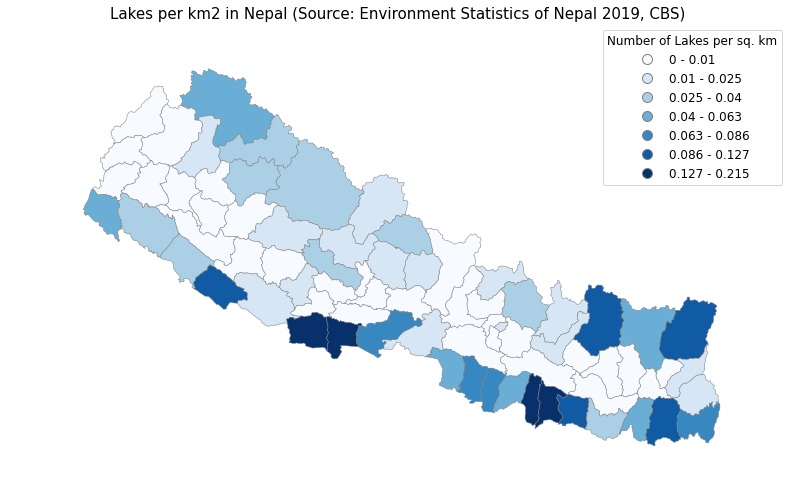

In [13]:
scheme = mc.FisherJenks(unit_lake_data['Total Lake'], k=7)
gplt.choropleth(
    unit_lake_data, figsize=(14,9),
    hue='Total Lake', projection=gcrs.AlbersEqualArea(),
    cmap='Blues', linewidth=0.5, edgecolor='gray',
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Number of Lakes per sq. km",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

plt.title("Lakes per km2 in Nepal (Source: Environment Statistics of Nepal 2019, CBS)", fontdict={"fontsize": 15}, pad=5)
# plt.savefig('../visualizations/LakesPuAreaNepal.svg', bbox_inches='tight')